%% RSI

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
import mpl_finance as mpf
from scipy import integrate
from scipy.stats import t
%matplotlib inline

In [46]:
    ticker='BA'
    startdate='2016-01-01'
    enddate='2019-07-22'
    df=yf.download(ticker,start=startdate,end=enddate)

[*********************100%***********************]  1 of 1 downloaded


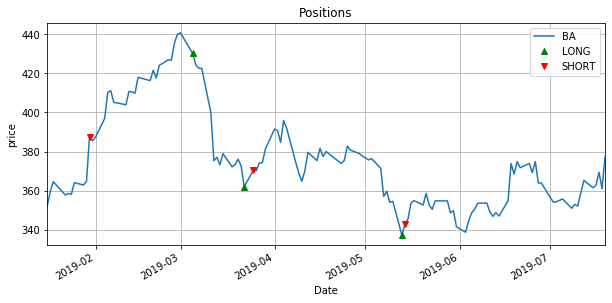

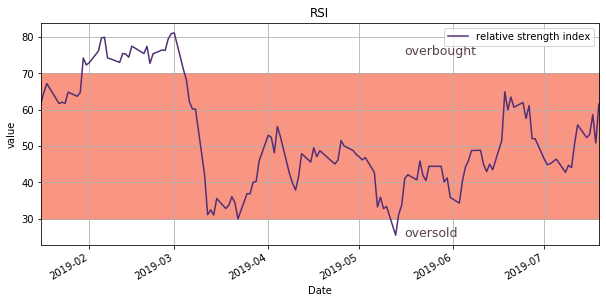

In [47]:
def smma(series,n):

    output=[series[0]]

    for i in range(1,len(series)):
        temp=output[-1]*(n-1)+series[i]
        output.append(temp/n)

    return output

def rsi(data,n=14):

    delta=data.diff().dropna()
    up=np.where(delta>0,delta,0)
    down=np.where(delta<0,-delta,0)
    rs=np.divide(smma(up,n),smma(down,n))
    output=100-100/(1+rs)
    
    return output[n-1:]

def signal_generation(df,method,n=14):

    df['rsi']=0.0
    df['rsi'][n:]=method(df['Close'],n=14)
    df['positions']=np.select([df['rsi']<30,df['rsi']>70], [1,-1],default=0)
    df['signals']=df['positions'].diff()
    
    return df[n:]

def plot(new,ticker):

    fig=plt.figure(figsize=(10,10))
    ax=fig.add_subplot(211)

    new['Close'].plot(label=ticker)
    ax.plot(new.loc[new['signals']==1].index,
            new['Close'][new['signals']==1],
            label='LONG',lw=0,marker='^',c='g')
    ax.plot(new.loc[new['signals']==-1].index,
            new['Close'][new['signals']==-1],
            label='SHORT',lw=0,marker='v',c='r')


    plt.legend(loc='best')
    plt.grid(True)
    plt.title('Positions')
    plt.xlabel('Date')
    plt.ylabel('price')

    plt.show()

    #the second plot is rsi with overbought/oversold interval capped at 30/70
    bx=plt.figure(figsize=(10,10)).add_subplot(212,sharex=ax)
    new['rsi'].plot(label='relative strength index',c='#522e75')
    bx.fill_between(new.index,30,70,alpha=0.5,color='#f22f08')

    bx.text(new.index[-45],75,'overbought',color='#594346',size=12.5)
    bx.text(new.index[-45],25,'oversold',color='#594346',size=12.5)

    plt.xlabel('Date')
    plt.ylabel('value')
    plt.title('RSI')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

def main():
    
    warnings.simplefilter('ignore')


    
    new=signal_generation(df,rsi,n=14)
    
    slicer=750
    new=new[slicer:]

    plot(new,ticker)
    
if __name__ == '__main__':
    main()

%% MACD

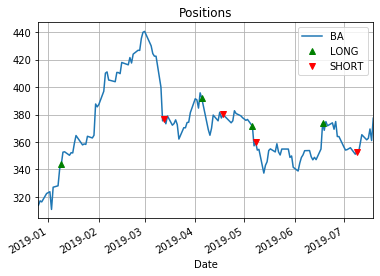

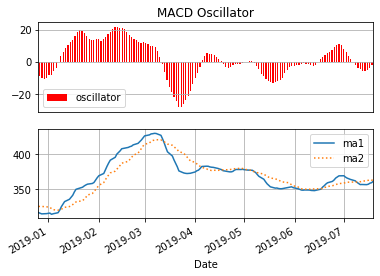

In [48]:
def macd(signals):
    
    global ma1
    global ma2
    
    signals['ma1']=signals['Close'].rolling(window=ma1,min_periods=1,center=False).mean()
    signals['ma2']=signals['Close'].rolling(window=ma2,min_periods=1,center=False).mean()
    
    return signals

def signal_generation(df,method):
    
    signals=method(df)
    signals['positions']=0
    signals['positions'][ma1:]=np.where(signals['ma1'][ma1:]>=signals['ma2'][ma1:],1,0)
    signals['signals']=signals['positions'].diff()
    signals['oscillator']=signals['ma1']-signals['ma2']

    return signals

def plot(new, ticker):

    fig=plt.figure()
    ax=fig.add_subplot(111)
    
    new['Close'].plot(label=ticker)
    ax.plot(new.loc[new['signals']==1].index,new['Close'][new['signals']==1],label='LONG',lw=0,marker='^',c='g')
    ax.plot(new.loc[new['signals']==-1].index,new['Close'][new['signals']==-1],label='SHORT',lw=0,marker='v',c='r')

    plt.legend(loc='best')
    plt.grid(True)
    plt.title('Positions')
    
    plt.show()

    fig=plt.figure()
    cx=fig.add_subplot(211)

    new['oscillator'].plot(kind='bar',color='r')

    plt.legend(loc='best')
    plt.grid(True)
    plt.xticks([])
    plt.xlabel('')
    plt.title('MACD Oscillator')

    bx=fig.add_subplot(212)

    new['ma1'].plot(label='ma1')
    new['ma2'].plot(label='ma2',linestyle=':')
    
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
def main():

    global ma1
    global ma2
    
    ma1=10
    ma2=21
    
    new=signal_generation(df,macd)
    
    slicer=750
    new=new[slicer:]
    
    plot(new, ticker)

if __name__ == '__main__':
    main()

%% Parabolic SAR

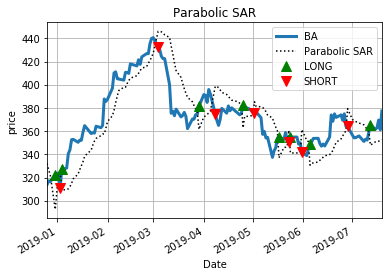

In [52]:
def parabolic_sar(new):

    initial_af=0.02
    step_af=0.02
    end_af=0.2
    
    
    new['trend']=0
    new['sar']=0.0
    new['real sar']=0.0
    new['ep']=0.0
    new['af']=0.0
    new['trend'][1]=1 if new['Close'][1]>new['Close'][0] else -1
    new['sar'][1]=new['High'][0] if new['trend'][1]>0 else new['Low'][0]
    new.at[1,'real sar']=new['sar'][1]
    new['ep'][1]=new['High'][1] if new['trend'][1]>0 else new['Low'][1]
    new['af'][1]=initial_af

    for i in range(2,len(new)):
        
        temp=new['sar'][i-1]+new['af'][i-1]*(new['ep'][i-1]-new['sar'][i-1])
        if new['trend'][i-1]<0:
            new.at[i,'sar']=max(temp,new['High'][i-1],new['High'][i-2])
            temp=1 if new['sar'][i]<new['High'][i] else new['trend'][i-1]-1
        else:
            new.at[i,'sar']=min(temp,new['Low'][i-1],new['Low'][i-2])
            temp=-1 if new['sar'][i]>new['Low'][i] else new['trend'][i-1]+1
        new.at[i,'trend']=temp
    
        
        if new['trend'][i]<0:
            temp=min(new['Low'][i],new['ep'][i-1]) if new['trend'][i]!=-1 else new['Low'][i]
        else:
            temp=max(new['High'][i],new['ep'][i-1]) if new['trend'][i]!=1 else new['High'][i]
        new.at[i,'ep']=temp
    
    
        if np.abs(new['trend'][i])==1:
            temp=new['ep'][i-1]
            new.at[i,'af']=initial_af
        else:
            temp=new['sar'][i]
            if new['ep'][i]==new['ep'][i-1]:
                new.at[i,'af']=new['af'][i-1]
            else:
                new.at[i,'af']=min(end_af,new['af'][i-1]+step_af)
        new.at[i,'real sar']=temp
       
        
    return new

def signal_generation(df,method):
    
        new=method(df)

        new['positions'],new['signals']=0,0
        new['positions']=np.where(new['real sar']<new['Close'],1,0)
        new['signals']=new['positions'].diff()
        
        return new

def plot(new,ticker):
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    
    new['Close'].plot(lw=3,label='%s'%ticker)
    new['real sar'].plot(linestyle=':',label='Parabolic SAR',color='k')
    ax.plot(new.loc[new['signals']==1].index,new['Close'][new['signals']==1],marker='^',color='g',label='LONG',lw=0,markersize=10)
    ax.plot(new.loc[new['signals']==-1].index,new['Close'][new['signals']==-1],marker='v',color='r',label='SHORT',lw=0,markersize=10)
    
    plt.legend()
    plt.grid(True)
    plt.title('Parabolic SAR')
    plt.ylabel('price')
    plt.show()
    
def main():
    
    new = df.copy()
    
    del new['Adj Close']
    del new['Volume']

    new.reset_index(inplace=True)
    new=signal_generation(new,parabolic_sar)    
    new.set_index(new['Date'],inplace=True)

    slicer=750
    new=new[slicer:]
    plot(new,ticker) 

if __name__ == '__main__':
    main()

%% Heikin-Ashi

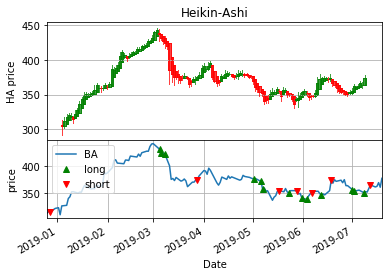

In [53]:
def heikin_ashi(df1):
    
    df1.reset_index(inplace=True)
    
    df1['HA close']=(df1['Open']+df1['Close']+df1['High']+df1['Low'])/4
    df1['HA open']=float(0)
    df1['HA open'][0]=df1['Open'][0]

    for n in range(1,len(df1)):
        df1.at[n,'HA open']=(df1['HA open'][n-1]+df1['HA close'][n-1])/2

    temp=pd.concat([df1['HA open'],df1['HA close'],df1['Low'],df1['High']],axis=1)
    df1['HA high']=temp.apply(max,axis=1)
    df1['HA low']=temp.apply(min,axis=1)

    del df1['Adj Close']
    del df1['Volume']
    return df1

def signal_generation(df,method,stls):
        
    df1=method(df)
    
    df1['signals']=0
    df1['cumsum']=0

    for n in range(1,len(df1)):
        
        if (df1['HA open'][n]>df1['HA close'][n] and df1['HA open'][n]==df1['HA high'][n] and
            np.abs(df1['HA open'][n]-df1['HA close'][n])>np.abs(df1['HA open'][n-1]-df1['HA close'][n-1]) and
            df1['HA open'][n-1]>df1['HA close'][n-1]):
            
            df1.at[n,'signals']=1
            df1['cumsum']=df1['signals'].cumsum()

            if df1['cumsum'][n]>stls:
                df1.at[n,'signals']=0
        

        elif (df1['HA open'][n]<df1['HA close'][n] and df1['HA open'][n]==df1['HA low'][n] and 
        df1['HA open'][n-1]<df1['HA close'][n-1]):
            
            df1.at[n,'signals']=-1
            df1['cumsum']=df1['signals'].cumsum()

            if df1['cumsum'][n]>0:
                df1.at[n,'signals']=-1*(df1['cumsum'][n-1])

            if df1['cumsum'][n]<0:
                df1.at[n,'signals']=0
                
    return df1

def plot(df1,ticker):
    
    
    df1.set_index(df1['Date'],inplace=True)
    ax1=plt.subplot2grid((200,1), (0,0), rowspan=120,ylabel='HA price')
    mpf.candlestick2_ochl(ax1, df1['HA open'], df1['HA close'], df1['HA high'], df1['HA low'], width=1, colorup='g', colordown='r')
    plt.grid(True)
    plt.xticks([])
    plt.title('Heikin-Ashi')

    ax2=plt.subplot2grid((200,1), (120,0), rowspan=80,ylabel='price',xlabel='')
    df1['Close'].plot(ax=ax2,label=ticker)

    ax2.plot(df1.loc[df1['signals']==1].index,df1['Close'][df1['signals']==1],marker='^',lw=0,c='g',label='long')
    ax2.plot(df1.loc[df1['signals']<0].index,df1['Close'][df1['signals']<0],marker='v',lw=0,c='r',label='short')

    plt.grid(True)
    plt.legend(loc='best')
    plt.show()
    
def omega(risk_free,degree_of_freedom,maximum,minimum):

    y=integrate.quad(lambda g:1-t.cdf(g,degree_of_freedom),risk_free,maximum)
    x=integrate.quad(lambda g:t.cdf(g,degree_of_freedom),minimum,risk_free)
    z=(y[0])/(x[0])
    
    return z

def sortino(risk_free,degree_of_freedom,growth_rate,minimum):

    v=np.sqrt(np.abs(integrate.quad(lambda g:((risk_free-g)**2)*t.pdf(g,degree_of_freedom),risk_free,minimum)))
    s=(growth_rate-risk_free)/v[0]

    return s

def mdd(series):

    temp=0
    for i in range(1,len(series)):
        if temp>(series[i]/max(series[:i])-1):
            temp=(series[i]/max(series[:i])-1)

    return temp

def main():
    
    
    stls=3
    new=signal_generation(df,heikin_ashi,stls)
    
    slicer=750
    new=new[slicer:]
    
    plot(new,ticker)

if __name__ == '__main__':
    main()